Loading training data...
          Time AMF_UE_NGAP_ID   ip_source procedureCode  EPD spare SecHdr  \
0     1.789354             -1   20.0.2.10            15  126     0      0   
1     1.799491              0  20.0.20.10             4  126     0      0   
2     1.799763              0   20.0.2.10            46  126     0      0   
3     1.802804              0  20.0.20.10             4  126     0      3   
4     1.803024              0   20.0.2.10            46  126     0      4   
..         ...            ...         ...           ...  ...   ...    ...   
795  21.591084             99  20.0.20.10             4  126     0      3   
796  21.591248             99   20.0.2.10            46  126     0      4   
797  21.612189             99  20.0.20.10            14  126     0      2   
798   21.61246             99   20.0.2.10            46  126     0      2   
799  21.612552             99   20.0.2.10            46  126     0      2   

    Type Seqn SecHdr_2 SecHdr_3 Type_2  
0     65 

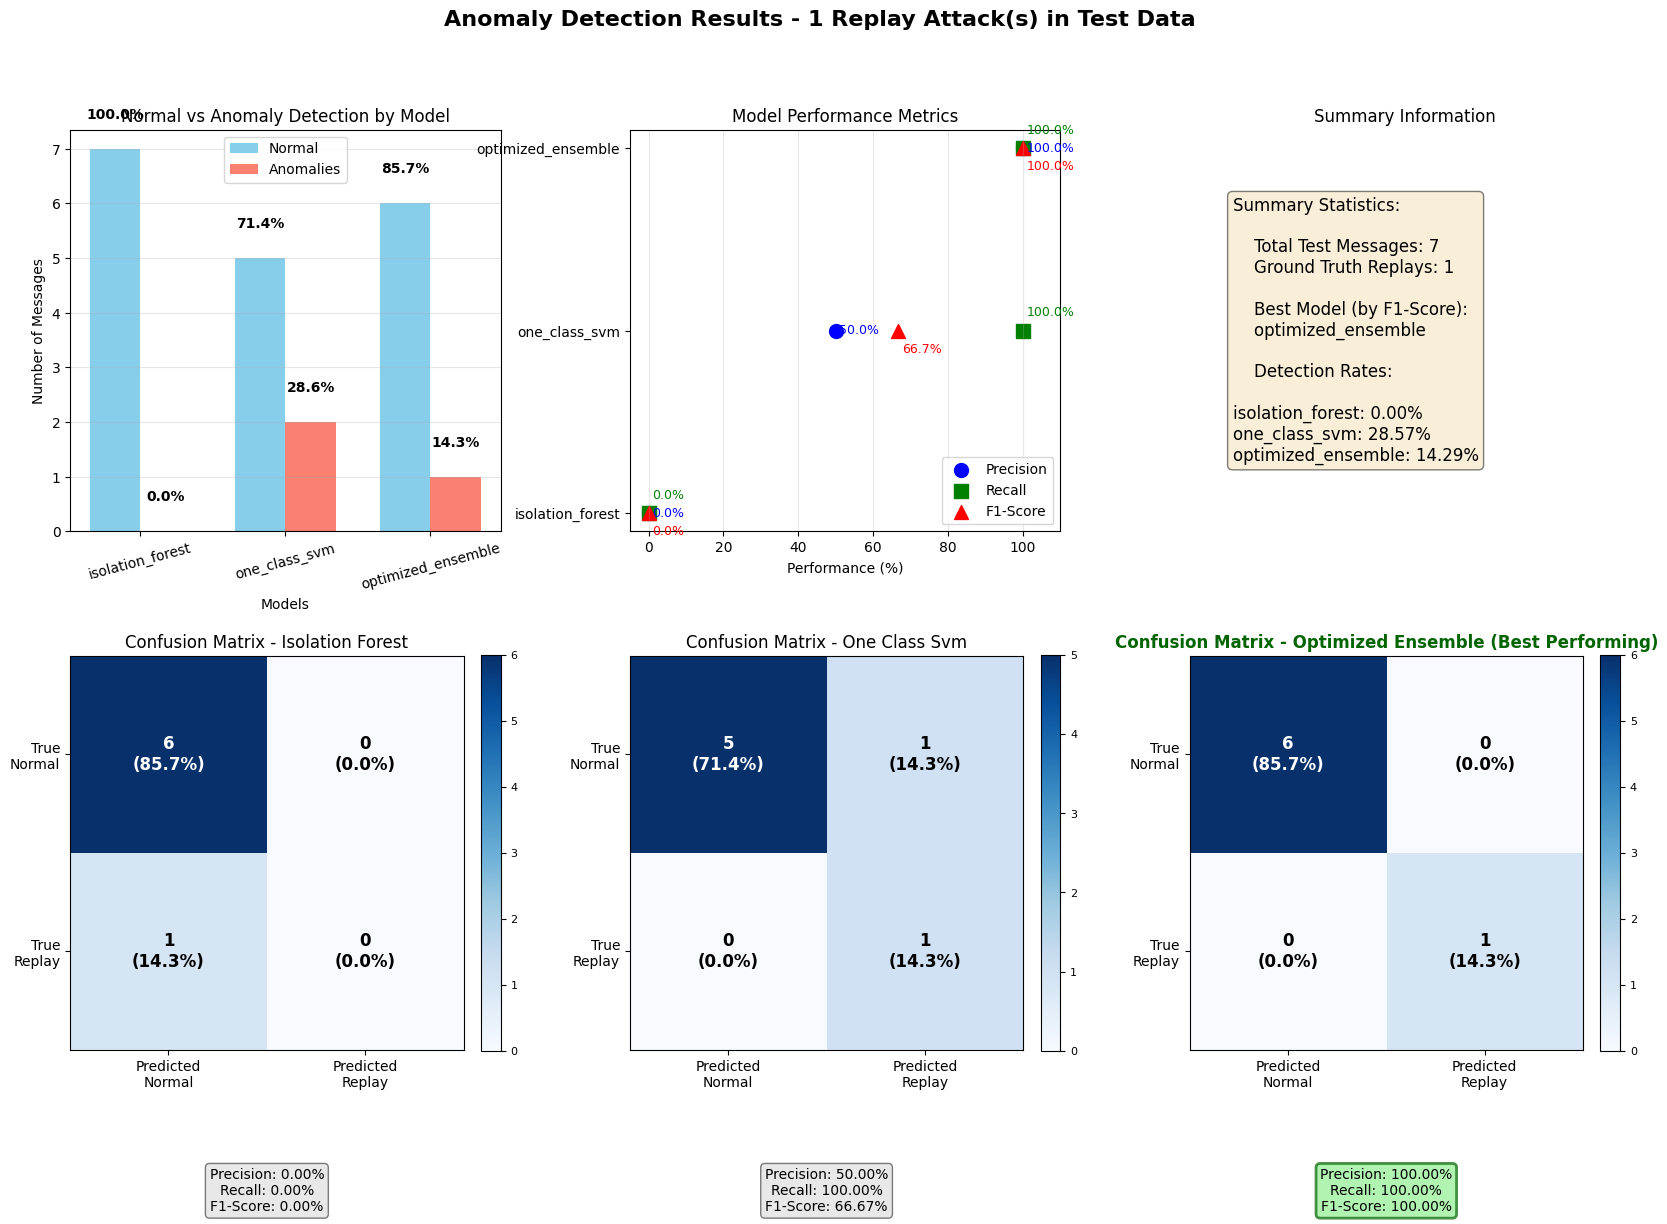

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid
from collections import defaultdict
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')


""" Two different algorithms is used. The model will use the best algorithm that predicted well"""

class OptimizedNASReplayDetector:
    def __init__(self):
        # ML components with optimized settings
        self.scaler = StandardScaler()
        self.models = {
            'isolation_forest': IsolationForest(contamination=0.001, random_state=42),
            'one_class_svm': OneClassSVM(nu=0.001, kernel='rbf', gamma='auto')
        }
        self.trained_models = {}
        self.feature_columns = None
        self.contamination_rate = 0.001  # Very low contamination rate
        self.ensemble_weights = {'isolation_forest': 0.3, 'one_class_svm': 0.7}
        self.optimal_threshold = None
        self.model_thresholds = {}
        self.confidence_thresholds = {}  #confidence thresholds
        
        # Sequence detector components
        self.session_messages = defaultdict(list)
        self.feature_stats = {}
        self.normal_behavior_profiles = {}
        
    def preprocess_data(self, df):
        """String data are converted to proper types"""
        df = df.copy()
        numeric_cols = ['Time', 'AMF_UE_NGAP_ID', 'procedureCode', 'Type', 'Seqn', 'SecHdr']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        return df
    
    def build_normal_behavior_profile(self, train_df):
        """ The training data is used to Build normal detailed behaviour profile """
        print("\nBuilding normal behavior profile...")
        
        uplink_df = train_df[train_df['procedureCode'].isin([46, 15])].copy()
        
        self.normal_behavior_profiles = {
            'time_gaps': [],
            'sequence_patterns': defaultdict(list),
            'type_transitions': defaultdict(int),
            'session_lengths': []
        }
        
        """Uisng Uplink data only """
        for session_id in uplink_df['AMF_UE_NGAP_ID'].unique():
            session_data = uplink_df[uplink_df['AMF_UE_NGAP_ID'] == session_id].sort_values('Time')
            
            if len(session_data) > 1:
                # Time gaps
                time_diffs = session_data['Time'].diff().dropna()
                self.normal_behavior_profiles['time_gaps'].extend(time_diffs.tolist())
                
                # Sequence patterns
                seq_diffs = session_data['Seqn'].diff().dropna()
                for seq_diff in seq_diffs:
                    self.normal_behavior_profiles['sequence_patterns'][session_id].append(seq_diff)
                
                # Type transitions
                types = session_data['Type'].tolist()
                for i in range(len(types) - 1):
                    transition = f"{types[i]}->{types[i+1]}"
                    self.normal_behavior_profiles['type_transitions'][transition] += 1
                
                # Session length
                session_duration = session_data['Time'].max() - session_data['Time'].min()
                self.normal_behavior_profiles['session_lengths'].append(session_duration)
        
        # Calculate statistics
        """Computing numerical summaries (percentiles) from the collected 
        time differences between messages in normal sessions."""

        if self.normal_behavior_profiles['time_gaps']:
            self.normal_behavior_profiles['min_normal_time_gap'] = np.percentile(
                self.normal_behavior_profiles['time_gaps'], 0.1
            )
            self.normal_behavior_profiles['typical_time_gap_range'] = (
                np.percentile(self.normal_behavior_profiles['time_gaps'], 5),
                np.percentile(self.normal_behavior_profiles['time_gaps'], 95)
            )
        
        print(f"  Minimum normal time gap: {self.normal_behavior_profiles.get('min_normal_time_gap', 0):.6f}s")
    
    def engineer_features_optimized(self, df, is_training=False):
        """Optimized feature engineering to minimize false positives"""
        # Filter uplink messages
        uplink_df = df[df['procedureCode'].isin([46, 15])].copy()
        uplink_df = uplink_df.sort_values('Time').reset_index(drop=True)
        
        features = pd.DataFrame()
        
        # Raw features in the dataframe from the training dataset
        features['time'] = uplink_df['Time']
        features['session_id'] = uplink_df['AMF_UE_NGAP_ID']
        # fill empty rows with -1 so that the model does not throw an error
        features['sequence'] = uplink_df['Seqn'].fillna(-1)
        features['type'] = uplink_df['Type']
        features['sec_hdr'] = uplink_df['SecHdr']
        
        # Process each session
        for session_id in features['session_id'].unique():
            mask = features['session_id'] == session_id
            session_data = features[mask]
            
            # Core features
            features.loc[mask, 'time_diff'] = session_data['time'].diff().fillna(0)
            features.loc[mask, 'seq_diff'] = session_data['sequence'].diff().fillna(1)
            features.loc[mask, 'position'] = range(len(session_data))
            
            # Time-based features with normalization
            features.loc[mask, 'time_since_start'] = session_data['time'] - session_data['time'].min()
            features.loc[mask, 'time_since_last'] = features.loc[mask, 'time_diff']
            
            # Rolling statistics (more stable)
            window = min(5, len(session_data))
            if window >= 2:
                features.loc[mask, 'time_diff_rolling_mean'] = (
                    features.loc[mask, 'time_diff'].rolling(window, min_periods=1).mean()
                )
                features.loc[mask, 'time_diff_rolling_std'] = (
                    features.loc[mask, 'time_diff'].rolling(window, min_periods=1).std().fillna(0)
                )
            else:
                features.loc[mask, 'time_diff_rolling_mean'] = features.loc[mask, 'time_diff']
                features.loc[mask, 'time_diff_rolling_std'] = 0
            
           
            # Ultra-fast replay (key indicator)
            min_gap = self.normal_behavior_profiles.get('min_normal_time_gap', 0.0001)
            features.loc[mask, 'ultra_fast_replay'] = (
                (features.loc[mask, 'time_diff'] > 0) & 
                (features.loc[mask, 'time_diff'] < min_gap * 0.1)  # 10% of minimum normal gap
            ).astype(int)
            
            # Exact sequence repeat (strongest indicator)
            features.loc[mask, 'exact_seq_repeat'] = (
                (features.loc[mask, 'seq_diff'] == 0) & 
                (features.loc[mask, 'position'] > 0)
            ).astype(int)
            
            # Backward sequence (if a lower sequence number appear after a higher one "suspicious but not always replay")
            features.loc[mask, 'backward_sequence'] = (
                (features.loc[mask, 'seq_diff'] < 0) & 
                (features.loc[mask, 'position'] > 0)
            ).astype(int)
            
            # Context-aware anomaly score
            if len(session_data) >= 3:
                # Z-score but with robust scaling
                """This detect if a message timing is abnormally early or late compared to recent behavior in that session"""
                mean_diff = features.loc[mask, 'time_diff_rolling_mean']
                std_diff = features.loc[mask, 'time_diff_rolling_std']
                features.loc[mask, 'time_anomaly_zscore'] = np.where(
                    std_diff > 0,
                    np.abs((features.loc[mask, 'time_diff'] - mean_diff) / std_diff),
                    0
                )
            else:
                features.loc[mask, 'time_anomaly_zscore'] = 0
            
            #  Message density (messages per second in recent window)
            features.loc[mask, 'recent_msg_density'] = np.where(
                features.loc[mask, 'time_since_last'] > 0,
                1 / features.loc[mask, 'time_since_last'],
                0
            )
            
            # Type consistency check
            features.loc[mask, 'type_changed'] = (
                session_data['type'].diff().fillna(0) != 0
            ).astype(int)
        
        # Create highly targeted replay risk score
        features['replay_confidence'] = (
            features['ultra_fast_replay'] * 5 +      # Highest weight
            features['exact_seq_repeat'] * 4 +        # Very high weight
            (features['time_anomaly_zscore'] > 5).astype(int) * 2 +  # High threshold
            features['backward_sequence'] * 1 +       # Lower weight
            (features['recent_msg_density'] > 1000).astype(int) * 1  # Very high density
        )
        
        # Normalize confidence score
        """Scale the replay confidence between 0 and 1. 
        find the maximum by diving the replay confidence value  by the maximum. the higest becomes 1."""
        if features['replay_confidence'].max() > 0:
            features['normalized_confidence'] = features['replay_confidence'] / features['replay_confidence'].max()
        else:
            features['normalized_confidence'] = 0
        
        # Selected streamlined features for the model training
        feature_cols = [
            'time_diff', 'seq_diff', 'position', 'time_since_start',
            'time_diff_rolling_mean', 'time_diff_rolling_std',
            'ultra_fast_replay', 'exact_seq_repeat', 'backward_sequence',
            'time_anomaly_zscore', 'recent_msg_density',
            'replay_confidence', 'normalized_confidence'
        ]
        
        #fill in any NAN rows with 0's
        model_features = features[feature_cols].fillna(0)
        
        return model_features, uplink_df
    
    def optimize_hyperparameters_targeted(self, X_train, y_train_pseudo):
        """This function tries different sets of parameters for the two algorithms 
        "Isolation Forest and One-Class SVM" in order to find the best for detecting anomalies in dataset."""
        print("\n" + "="*70)
        print("TARGETED HYPERPARAMETER OPTIMIZATION")
        print("="*70)
        
        best_params = {}
        
        # Very conservative contamination rates
        contamination_rates = [0.0005, 0.001, 0.002, 0.003]
        
        # Isolation Forest optimization
        iso_param_grid = {
            'contamination': contamination_rates,
            'n_estimators': [150, 200, 250],
            'max_samples': [0.7, 0.8, 'auto'],
            'max_features': [0.7, 0.8, 0.9],
            'bootstrap': [False]  # More stable without bootstrap
        }
        
        print("\nOptimizing Isolation Forest...")
        best_score = float('inf')
        best_iso_params = None

        # Generates all possible combinations of the hyperparameters and selecting the best metric.
        
        for params in ParameterGrid(iso_param_grid):
            model = IsolationForest(random_state=42, **params)
            model.fit(X_train)
            
            predictions = model.predict(X_train)
            
            # Prefer models that flag only high-confidence anomalies
            anomaly_indices = np.where(predictions == -1)[0]
            if len(anomaly_indices) > 0:
                # Check if anomalies correspond to high pseudo-label scores
                avg_pseudo_score = y_train_pseudo[anomaly_indices].mean()
                penalty = len(anomaly_indices) / len(X_train)  # Penalize too many anomalies
                
                score = penalty - avg_pseudo_score  # Lower is better
                
                if score < best_score and penalty < 0.01:  # Max 1% anomalies
                    best_score = score
                    best_iso_params = params
        
        if best_iso_params is None:
            best_iso_params = {'contamination': 0.001, 'n_estimators': 200, 
                              'max_samples': 'auto', 'max_features': 0.8, 'bootstrap': False}
        
        print(f"Best Isolation Forest params: {best_iso_params}")
        best_params['isolation_forest'] = best_iso_params
        
        # One-Class SVM optimization
        svm_param_grid = {
            'nu': contamination_rates,
            'kernel': ['rbf'],
            'gamma': ['scale', 0.0001, 0.001]
        }
        
        print("\nOptimizing One-Class SVM...")
        best_score = float('inf')
        best_svm_params = None
        
        for params in ParameterGrid(svm_param_grid):
            try:
                model = OneClassSVM(**params)
                model.fit(X_train)
                
                predictions = model.predict(X_train)
                anomaly_indices = np.where(predictions == -1)[0]
                
                if len(anomaly_indices) > 0:
                    avg_pseudo_score = y_train_pseudo[anomaly_indices].mean()
                    penalty = len(anomaly_indices) / len(X_train)
                    score = penalty - avg_pseudo_score
                    
                    if score < best_score and penalty < 0.01:
                        best_score = score
                        best_svm_params = params
            except:
                continue
        
        if best_svm_params is None:
            best_svm_params = {'nu': 0.001, 'kernel': 'rbf', 'gamma': 'scale'}
        
        print(f"Best One-Class SVM params: {best_svm_params}")
        best_params['one_class_svm'] = best_svm_params
        
        # Update models
        self.models['isolation_forest'] = IsolationForest(random_state=42, **best_params['isolation_forest'])
        self.models['one_class_svm'] = OneClassSVM(**best_params['one_class_svm'])
        
        self.contamination_rate = best_params['isolation_forest']['contamination']
        
        return best_params
    
    def calculate_confidence_thresholds(self, X_train, features_df):
        """Calculate confidence-based thresholds"""
        print("\nCalculating confidence thresholds...")
        
        # Get replay confidence scores
        replay_confidences = features_df['replay_confidence'].values
        
        # Set very high threshold for anomaly detection
        confidence_threshold = np.percentile(replay_confidences, 99.9)  # Top 0.1%
        
        self.confidence_thresholds['min_confidence'] = max(confidence_threshold, 3.0)  # At least 3
        
        print(f"Minimum confidence threshold: {self.confidence_thresholds['min_confidence']:.2f}")
    
    def ensemble_predict_with_confidence(self, X_test, test_features):
        """Ensemble prediction with confidence filtering"""
        predictions = {}
        scores = {}
        
        # Get base model predictions
        for model_name, model in self.trained_models.items():
            if hasattr(model, 'decision_function'):
                scores[model_name] = model.decision_function(X_test)
            else:
                scores[model_name] = model.score_samples(X_test)
            
            predictions[model_name] = model.predict(X_test)
        
        # Start with all normal
        ensemble_predictions = np.ones(len(X_test))
        
        # Get replay confidence scores
        replay_confidences = test_features['replay_confidence'].values
        
        # Apply revised filtering logic
        for i in range(len(X_test)):
            # Count model votes
            model_votes = sum(predictions[model_name][i] == -1 for model_name in predictions)
            
            # Get confidence score
            confidence = replay_confidences[i]
            
            # Check for specific replay patterns
            has_exact_repeat = test_features.iloc[i]['exact_seq_repeat'] > 0
            has_ultra_fast = test_features.iloc[i]['ultra_fast_replay'] > 0
            
            # Revised logic - more balanced
            # Case 1: Very high confidence with exact repeat
            if confidence >= 5.0 and has_exact_repeat:
                ensemble_predictions[i] = -1
            # Case 2: High confidence with at least one model vote
            elif confidence >= 4.0 and model_votes >= 1:
                ensemble_predictions[i] = -1
            # Case 3: Both models agree
            elif model_votes >= 2:
                ensemble_predictions[i] = -1
            # Case 4: One model with very strong replay indicators
            elif model_votes >= 1 and (has_exact_repeat or has_ultra_fast) and confidence >= 3.0:
                ensemble_predictions[i] = -1
        
        # Calculate ensemble scores
        ensemble_score = np.zeros(len(X_test))
        for model_name in scores:
            min_score = scores[model_name].min()
            max_score = scores[model_name].max()
            if max_score > min_score:
                normalized = (scores[model_name] - min_score) / (max_score - min_score)
                ensemble_score += normalized * self.ensemble_weights[model_name]
        
        return ensemble_predictions, ensemble_score
    
    def train(self, train_data, optimize_params=True):
        """Train ML models"""
        print("="*70)
        
        train_df = self.preprocess_data(train_data)
        print(train_df)
        
        # Build normal behavior profile
        self.build_normal_behavior_profile(train_df)
        
        # Engineer features
        features, uplink_df = self.engineer_features_optimized(train_df, is_training=True)
        print(f"preprocess data: {features}")
        
        print(f"\nTraining on {len(uplink_df)} uplink messages")
        print(f"Feature dimensions: {features.shape}")
        
        # Create pseudo-labels based on replay confidence
        y_train_pseudo = features['replay_confidence'].values
        
        # Report high-risk samples
        high_risk = (features['replay_confidence'] >= 3).sum()
        very_high_risk = (features['replay_confidence'] >= 5).sum()
        
        # print(f"High risk samples (confidence >= 3): {high_risk}")
        # print(f"Very high risk samples (confidence >= 5): {very_high_risk}")
        
        self.feature_columns = features.columns.tolist()
        X_train = self.scaler.fit_transform(features)
        
        # Optimize hyperparameters with pseudo-labels
        if optimize_params:
            best_params = self.optimize_hyperparameters_targeted(X_train, y_train_pseudo)
        
        # Train models
        for model_name, model in self.models.items():
            print(f"\nTraining {model_name}...")
            model.fit(X_train)
            self.trained_models[model_name] = model
            
            predictions = model.predict(X_train)
            anomaly_rate = (predictions == -1).sum() / len(predictions)
            print(f"  Training anomaly rate: {anomaly_rate:.2%}")
        
        # Calculate confidence thresholds
        self.calculate_confidence_thresholds(X_train, features)
        
        # Set conservative ensemble weights
        self.ensemble_weights = {'isolation_forest': 0.4, 'one_class_svm': 0.6}
        
        print("\nTraining complete!")
    
    def detect_sequence_replays(self, df):
        """Detect true replay attacks based on sequence reuse"""
        self.session_messages.clear()
        df = self.preprocess_data(df)
        df = df.sort_values('Time').reset_index(drop=True)
        
        replays = []
        
        for idx, row in df.iterrows():
            session_id = row['AMF_UE_NGAP_ID']
            seq_num = row['Seqn']
            proc_code = row['procedureCode']
            msg_type = row['Type']
            time = row['Time']
            
            if pd.isna(seq_num) or pd.isna(session_id):
                continue
            
            # Only check uplink messages
            if proc_code not in [46, 15]:
                continue
            
            # Check session history
            for prev_msg in self.session_messages[session_id]:
                if (prev_msg['seq'] == seq_num and 
                    prev_msg['type'] == msg_type and 
                    prev_msg['proc_code'] == proc_code):
                    
                    # Found a replay
                    time_diff = time - prev_msg['time']
                    
                    # Only consider it a replay if there's some time difference
                    if abs(time_diff) > 1e-6:
                        replays.append({
                            'replay_idx': idx,
                            'replay_time': time,
                            'original_idx': prev_msg['idx'],
                            'original_time': prev_msg['time'],
                            'session_id': session_id,
                            'sequence': seq_num,
                            'message_type': msg_type,
                            'time_diff': time_diff
                        })
                        print(f"\nReplay detected: Session {session_id}, Seq {seq_num}, Time diff: {time_diff:.6f}s")
            
            # Add to history
            self.session_messages[session_id].append({
                'seq': seq_num,
                'type': msg_type,
                'proc_code': proc_code,
                'time': time,
                'idx': idx
            })
        
        return replays
    
    def test(self, test_data, use_ensemble=True):
        """Test ML models"""
        print("\n" + "="*70)
        
        # Get ground truth replays
        sequence_replays = self.detect_sequence_replays(test_data)
        print(f"\nGround truth: {len(sequence_replays)} replay attacks found")
        
        # Prepare test data
        test_df = self.preprocess_data(test_data)
        features, uplink_df = self.engineer_features_optimized(test_df, is_training=False)
      

        print(f"\nTesting on {len(uplink_df)} uplink messages")
        print(f"Feature dimensions: {features.shape}")
        
        # Detailed feature analysis
        print(f"\nTest data analysis:")
        print(f"Total uplink messages: {len(uplink_df)}")
        print(f"Ultra-fast replays: {features['ultra_fast_replay'].sum()}")
        print(f"Exact sequence repeats: {features['exact_seq_repeat'].sum()}")
        print(f"High confidence (>= 3): {(features['replay_confidence'] >= 3).sum()}")
        print(f"Very high confidence (>= 5): {(features['replay_confidence'] >= 5).sum()}")
        
        # Show specific high-confidence samples
        high_conf_indices = features[features['replay_confidence'] >= 3].index.tolist()
        if high_conf_indices:
            print(f"\nHigh confidence sample indices: {high_conf_indices}")
            for idx in high_conf_indices[:3]:
                print(f"  Index {idx}: confidence={features.iloc[idx]['replay_confidence']:.1f}, "
                      f"ultra_fast={features.iloc[idx]['ultra_fast_replay']}, "
                      f"seq_repeat={features.iloc[idx]['exact_seq_repeat']}")
        
        # Ensure same features as training
        for col in self.feature_columns:
            if col not in features.columns:
                features[col] = 0
        features_for_model = features[self.feature_columns]
        
        X_test = self.scaler.transform(features_for_model)
        
        # Map replay indices
        uplink_mapping = {}
        uplink_idx = 0
        for orig_idx, is_uplink in enumerate(test_df['procedureCode'].isin([46, 15])):
            if is_uplink:
                uplink_mapping[orig_idx] = uplink_idx
                uplink_idx += 1
        
        # Get true labels
        y_true = np.zeros(len(uplink_df))
        for replay in sequence_replays:
            if replay['replay_idx'] in uplink_mapping:
                y_true[uplink_mapping[replay['replay_idx']]] = 1
                print(f"True replay at uplink index: {uplink_mapping[replay['replay_idx']]}")
        
        results = {}
        
        # Test individual models
        for model_name, model in self.trained_models.items():
            predictions = model.predict(X_test)
            
            if hasattr(model, 'decision_function'):
                scores = model.decision_function(X_test)
            else:
                scores = model.score_samples(X_test)
            
            y_pred = (predictions == -1).astype(int)
            
            # Calculate metrics
            tp = np.sum((y_true == 1) & (y_pred == 1))
            fp = np.sum((y_true == 0) & (y_pred == 1))
            fn = np.sum((y_true == 1) & (y_pred == 0))
            tn = np.sum((y_true == 0) & (y_pred == 0))
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            results[model_name] = {
                'predictions': y_pred,
                'scores': scores,
                'metrics': {
                    'true_positives': tp,
                    'false_positives': fp,
                    'false_negatives': fn,
                    'true_negatives': tn,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1
                },
                'uplink_df': uplink_df
            }
        
        # Optimized ensemble with confidence
        if use_ensemble:
            ensemble_predictions, ensemble_scores = self.ensemble_predict_with_confidence(X_test, features)
            y_pred_ensemble = (ensemble_predictions == -1).astype(int)
            
            tp = np.sum((y_true == 1) & (y_pred_ensemble == 1))
            fp = np.sum((y_true == 0) & (y_pred_ensemble == 1))
            fn = np.sum((y_true == 1) & (y_pred_ensemble == 0))
            tn = np.sum((y_true == 0) & (y_pred_ensemble == 0))
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            results['optimized_ensemble'] = {
                'predictions': y_pred_ensemble,
                'scores': ensemble_scores,
                'metrics': {
                    'true_positives': tp,
                    'false_positives': fp,
                    'false_negatives': fn,
                    'true_negatives': tn,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1
                },
                'uplink_df': uplink_df
            }
        
        return results, sequence_replays
    
    def analyze_replay_attacks(self, test_data, sequence_replays):
        """Detailed analysis of detected replay attacks"""
        if not sequence_replays:
            print("\n No replay attacks to analyze")
            return None
            
        print("\n" + "="*70)
        print("DETAILED REPLAY ATTACK ANALYSIS")
        print("="*70)
        
        # Get full data
        test_df = self.preprocess_data(test_data)
        
        # Create detailed analysis for each replay
        print(f"\nFound {len(sequence_replays)} replay attack(s):")
        print("\n" + "-"*100)
        
        for i, replay in enumerate(sequence_replays):
            print(f"\nREPLAY ATTACK #{i+1}")
            print("="*50)
            
            # Get original and replay messages
            original_msg = test_df.iloc[replay['original_idx']]
            replay_msg = test_df.iloc[replay['replay_idx']]
            
            # Display comparison
            print("\nOriginal Message:")
            print(f"  Time:      {original_msg['Time']:.6f}s")
            print(f"  Session:   {int(original_msg['AMF_UE_NGAP_ID'])}")
            print(f"  Sequence:  {int(original_msg['Seqn'])}")
            print(f"  Type:      {int(original_msg['Type'])}")
            print(f"  Proc Code: {int(original_msg['procedureCode'])}")
            print(f"  SecHdr:    {int(original_msg['SecHdr'])}")
            print(f"  IP Source: {original_msg['ip_source']}")
            
            print("\nReplayed Message:")
            print(f"  Time:      {replay_msg['Time']:.6f}s (+{replay['time_diff']:.6f}s)")
            print(f"  Session:   {int(replay_msg['AMF_UE_NGAP_ID'])}")
            print(f"  Sequence:  {int(replay_msg['Seqn'])}")
            print(f"  Type:      {int(replay_msg['Type'])}")
            print(f"  Proc Code: {int(replay_msg['procedureCode'])}")
            print(f"  SecHdr:    {int(replay_msg['SecHdr'])}")
            print(f"  IP Source: {replay_msg['ip_source']}")
            
            # Check for differences
            print("\nAnalysis:")
            print(f"  Time Difference: {replay['time_diff']:.6f} seconds")
            
            if original_msg['SecHdr'] != replay_msg['SecHdr']:
                print(f"  Security Header Changed: {int(original_msg['SecHdr'])} → {int(replay_msg['SecHdr'])}")
            
            if original_msg['ip_source'] != replay_msg['ip_source']:
                print(f"  IP Source Changed: {original_msg['ip_source']} → {replay_msg['ip_source']}")
                
            # Context: Show surrounding messages
            session_id = replay['session_id']
            session_msgs = test_df[test_df['AMF_UE_NGAP_ID'] == session_id].sort_values('Time')
            
            print("\nMessage Context (5 messages before and after):")
            print(f"{'Time':>12} {'Proc':>5} {'Type':>5} {'Seq':>5} {'Dir':>8} {'Note':>20}")
            print("-"*65)
            
            # Find position of original and replay in session
            for idx, row in session_msgs.iterrows():
                if abs(row['Time'] - original_msg['Time']) < 5.0 or abs(row['Time'] - replay_msg['Time']) < 5.0:
                    direction = "UPLINK" if row['procedureCode'] in [46, 15] else "DOWNLINK"
                    note = ""
                    if idx == replay['original_idx']:
                        note = "==== ORIGINAL"
                    elif idx == replay['replay_idx']:
                        note = "==== REPLAY!"
                    
                    seq_str = f"{int(row['Seqn'])}" if not pd.isna(row['Seqn']) else "NaN"
                    print(f"{row['Time']:>12.6f} {int(row['procedureCode']):>5} "
                          f"{int(row['Type']):>5} {seq_str:>5} {direction:>8} {note:>20}")
        
        return sequence_replays
    
    # def visualize_anomalies(self, results, sequence_replays):
    #     """Create enhanced visualizations for anomaly detection results"""
    #     # Create figure with 2 rows: top row for existing plots, bottom row for confusion matrices
    #     fig = plt.figure(figsize=(20, 12))
        
    #     # Create grid spec for better layout control
    #     gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], hspace=0.3, wspace=0.3)
        
    #     # Top row - existing plots
    #     ax1 = fig.add_subplot(gs[0, 0])
    #     ax2 = fig.add_subplot(gs[0, 1])
    #     ax3 = fig.add_subplot(gs[0, 2])
        
    #     # Bottom row - confusion matrices for all models
    #     ax4 = fig.add_subplot(gs[1, 0])
    #     ax5 = fig.add_subplot(gs[1, 1])
    #     ax6 = fig.add_subplot(gs[1, 2])
        
    #     # Prepare data
    #     model_names = list(results.keys())
        
    #     # PLOT 1: BAR CHART - Detection Counts with Percentages
    #     normal_counts = []
    #     anomaly_counts = []
    #     total_counts = []
        
    #     for model_name, result in results.items():
    #         predictions = result['predictions']
    #         normal = np.sum(predictions == 0)
    #         anomalies = np.sum(predictions == 1)
    #         total = len(predictions)
            
    #         normal_counts.append(normal)
    #         anomaly_counts.append(anomalies)
    #         total_counts.append(total)
        
    #     x = np.arange(len(model_names))
    #     width = 0.35
        
    #     bars1 = ax1.bar(x - width/2, normal_counts, width, label='Normal', color='skyblue')
    #     bars2 = ax1.bar(x + width/2, anomaly_counts, width, label='Anomalies', color='salmon')
        
    #     # Add percentage labels on bars
    #     for i, (normal, anomaly, total) in enumerate(zip(normal_counts, anomaly_counts, total_counts)):
    #         normal_pct = (normal / total) * 100
    #         anomaly_pct = (anomaly / total) * 100
            
    #         ax1.text(i - width/2, normal + 0.5, f'{normal_pct:.1f}%', 
    #                 ha='center', va='bottom', fontweight='bold')
    #         ax1.text(i + width/2, anomaly + 0.5, f'{anomaly_pct:.1f}%', 
    #                 ha='center', va='bottom', fontweight='bold')
        
    #     ax1.set_xlabel('Models')
    #     ax1.set_ylabel('Number of Messages')
    #     ax1.set_title('Normal vs Anomaly Detection by Model')
    #     ax1.set_xticks(x)
    #     ax1.set_xticklabels(model_names, rotation=15)
    #     ax1.legend()
    #     ax1.grid(True, alpha=0.3, axis='y')
        
    #     # PLOT 2: DOT PLOT - Performance Metrics
    #     metrics_data = []
    #     for model_name, result in results.items():
    #         m = result['metrics']
    #         metrics_data.append({
    #             'model': model_name,
    #             'precision': m['precision'] * 100,
    #             'recall': m['recall'] * 100,
    #             'f1_score': m['f1_score'] * 100
    #         })
        
    #     y_positions = np.arange(len(model_names))
        
    #     for i, data in enumerate(metrics_data):
    #         ax2.scatter(data['precision'], i, s=100, label='Precision' if i == 0 else '', 
    #                 color='blue', marker='o')
    #         ax2.scatter(data['recall'], i, s=100, label='Recall' if i == 0 else '', 
    #                 color='green', marker='s')
    #         ax2.scatter(data['f1_score'], i, s=100, label='F1-Score' if i == 0 else '', 
    #                 color='red', marker='^')
            
    #         # Add value labels
    #         ax2.text(data['precision'] + 1, i, f"{data['precision']:.1f}%", 
    #                 va='center', fontsize=9, color='blue')
    #         ax2.text(data['recall'] + 1, i + 0.1, f"{data['recall']:.1f}%", 
    #                 va='center', fontsize=9, color='green')
    #         ax2.text(data['f1_score'] + 1, i - 0.1, f"{data['f1_score']:.1f}%", 
    #                 va='center', fontsize=9, color='red')
        
    #     ax2.set_yticks(y_positions)
    #     ax2.set_yticklabels(model_names)
    #     ax2.set_xlabel('Performance (%)')
    #     ax2.set_title('Model Performance Metrics')
    #     ax2.set_xlim(-5, 110)
    #     ax2.legend(loc='lower right')
    #     ax2.grid(True, alpha=0.3, axis='x')
        
    #     # PLOT 3: Summary Statistics
    #     ax3.axis('off')
    #     summary_text = f"""Summary Statistics:
        
    # Total Test Messages: {len(results[list(results.keys())[0]]['predictions'])}
    # Ground Truth Replays: {len(sequence_replays)}

    # Best Model (by F1-Score):
    # {max(results.items(), key=lambda x: x[1]['metrics']['f1_score'])[0]}

    # Detection Rates:
    # """
    #     for model_name, result in results.items():
    #         anomaly_rate = (result['predictions'] == 1).sum() / len(result['predictions']) * 100
    #         summary_text += f"\n{model_name}: {anomaly_rate:.2f}%"
        
    #     ax3.text(0.1, 0.5, summary_text, transform=ax3.transAxes, 
    #             fontsize=12, verticalalignment='center',
    #             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    #     ax3.set_title('Summary Information')
        
    #     # PLOTS 4-6: CONFUSION MATRICES FOR ALL MODELS
    #     confusion_axes = [ax4, ax5, ax6]
        
    #     # Define order for consistency
    #     model_order = ['isolation_forest', 'one_class_svm', 'optimized_ensemble']
        
    #     for idx, model_name in enumerate(model_order):
    #         if model_name in results:
    #             ax = confusion_axes[idx]
    #             metrics = results[model_name]['metrics']
                
    #             # Create confusion matrix
    #             conf_matrix = np.array([
    #                 [metrics['true_negatives'], metrics['false_positives']],
    #                 [metrics['false_negatives'], metrics['true_positives']]
    #             ])
                
    #             # Plot heatmap
    #             im = ax.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
                
    #             # Create colorbar for this specific subplot
    #             cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    #             cbar.ax.tick_params(labelsize=8)
                
    #             # Add text annotations with values and percentages
    #             thresh = conf_matrix.max() / 2.
    #             for i in range(2):
    #                 for j in range(2):
    #                     value = conf_matrix[i, j]
    #                     total = conf_matrix.sum()
    #                     percentage = (value / total) * 100
                        
    #                     text = ax.text(j, i, f'{value}\n({percentage:.1f}%)',
    #                                 ha="center", va="center", 
    #                                 color="white" if conf_matrix[i, j] > thresh else "black",
    #                                 fontsize=12, fontweight='bold')
                
    #             ax.set_xticks([0, 1])
    #             ax.set_yticks([0, 1])
    #             ax.set_xticklabels(['Predicted\nNormal', 'Predicted\nReplay'])
    #             ax.set_yticklabels(['True\nNormal', 'True\nReplay'])
                
    #             # Highlight the best performing model in the title
    #             if model_name == 'optimized_ensemble':
    #                 title = f'Confusion Matrix - {model_name.replace("_", " ").title()} (Best Performing)'
    #                 ax.set_title(title, fontweight='bold', color='darkgreen')
    #             else:
    #                 ax.set_title(f'Confusion Matrix - {model_name.replace("_", " ").title()}')
                
    #             # Add performance metrics below the confusion matrix
    #             perf_text = f"Precision: {metrics['precision']:.2%}\nRecall: {metrics['recall']:.2%}\nF1-Score: {metrics['f1_score']:.2%}"
                
    #             # Highlight the metrics box for the best performing model
    #             if model_name == 'optimized_ensemble':
    #                 bbox_props = dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7, edgecolor='darkgreen', linewidth=2)
    #             else:
    #                 bbox_props = dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5)
                    
    #             ax.text(0.5, -0.3, perf_text, transform=ax.transAxes, 
    #                     ha='center', va='top', fontsize=10, bbox=bbox_props)
        
    #     # Add main title
    #     fig.suptitle(f'Anomaly Detection Results - {len(sequence_replays)} Replay Attack(s) in Test Data', 
    #                 fontsize=16, fontweight='bold')
        
    #     plt.tight_layout()
    #     plt.savefig('complete_anomaly_detection_visualizations.png', dpi=300, bbox_inches='tight')
    #     print("\nComplete visualizations with all confusion matrices saved as 'complete_anomaly_detection_visualizations.png'")
    #     plt.show()

    
    def visualize_anomalies(self, results, sequence_replays):
        """Create enhanced visualizations for anomaly detection results"""
        # Create figure with 2 rows: top row for existing plots, bottom row for confusion matrices
        fig = plt.figure(figsize=(20, 12))
        
        # Create grid spec for better layout control
        gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], hspace=0.3, wspace=0.3)
        
        # Top row - existing plots
        ax1 = fig.add_subplot(gs[0, 0])
        ax2 = fig.add_subplot(gs[0, 1])
        ax3 = fig.add_subplot(gs[0, 2])
        
        # Bottom row - confusion matrices for all models
        ax4 = fig.add_subplot(gs[1, 0])
        ax5 = fig.add_subplot(gs[1, 1])
        ax6 = fig.add_subplot(gs[1, 2])
        
        # Prepare data
        model_names = list(results.keys())
        
        # PLOT 1: BAR CHART - Detection Counts with Percentages
        normal_counts = []
        anomaly_counts = []
        total_counts = []
        
        for model_name, result in results.items():
            predictions = result['predictions']
            normal = np.sum(predictions == 0)
            anomalies = np.sum(predictions == 1)
            total = len(predictions)
            
            normal_counts.append(normal)
            anomaly_counts.append(anomalies)
            total_counts.append(total)
        
        x = np.arange(len(model_names))
        width = 0.35
        
        bars1 = ax1.bar(x - width/2, normal_counts, width, label='Normal', color='skyblue')
        bars2 = ax1.bar(x + width/2, anomaly_counts, width, label='Anomalies', color='salmon')
        
        # Add percentage labels on bars
        for i, (normal, anomaly, total) in enumerate(zip(normal_counts, anomaly_counts, total_counts)):
            normal_pct = (normal / total) * 100
            anomaly_pct = (anomaly / total) * 100
            
            ax1.text(i - width/2, normal + 0.5, f'{normal_pct:.1f}%', 
                    ha='center', va='bottom', fontweight='bold')
            ax1.text(i + width/2, anomaly + 0.5, f'{anomaly_pct:.1f}%', 
                    ha='center', va='bottom', fontweight='bold')
        
        ax1.set_xlabel('Models')
        ax1.set_ylabel('Number of Messages')
        ax1.set_title('Normal vs Anomaly Detection by Model')
        ax1.set_xticks(x)
        ax1.set_xticklabels(model_names, rotation=15)
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
        
        # PLOT 2: DOT PLOT - Performance Metrics
        metrics_data = []
        for model_name, result in results.items():
            m = result['metrics']
            metrics_data.append({
                'model': model_name,
                'precision': m['precision'] * 100,
                'recall': m['recall'] * 100,
                'f1_score': m['f1_score'] * 100
            })
        
        y_positions = np.arange(len(model_names))
        
        for i, data in enumerate(metrics_data):
            ax2.scatter(data['precision'], i, s=100, label='Precision' if i == 0 else '', 
                    color='blue', marker='o')
            ax2.scatter(data['recall'], i, s=100, label='Recall' if i == 0 else '', 
                    color='green', marker='s')
            ax2.scatter(data['f1_score'], i, s=100, label='F1-Score' if i == 0 else '', 
                    color='red', marker='^')
            
            # Add value labels
            ax2.text(data['precision'] + 1, i, f"{data['precision']:.1f}%", 
                    va='center', fontsize=9, color='blue')
            ax2.text(data['recall'] + 1, i + 0.1, f"{data['recall']:.1f}%", 
                    va='center', fontsize=9, color='green')
            ax2.text(data['f1_score'] + 1, i - 0.1, f"{data['f1_score']:.1f}%", 
                    va='center', fontsize=9, color='red')
        
        ax2.set_yticks(y_positions)
        ax2.set_yticklabels(model_names)
        ax2.set_xlabel('Performance (%)')
        ax2.set_title('Model Performance Metrics')
        ax2.set_xlim(-5, 110)
        ax2.legend(loc='lower right')
        ax2.grid(True, alpha=0.3, axis='x')
        
        # PLOT 3: Summary Statistics
        ax3.axis('off')
        summary_text = f"""Summary Statistics:
        
    Total Test Messages: {len(results[list(results.keys())[0]]['predictions'])}
    Ground Truth Replays: {len(sequence_replays)}

    Best Model (by F1-Score):
    {max(results.items(), key=lambda x: x[1]['metrics']['f1_score'])[0].replace('_', ' ').title()}"""
        
        ax3.text(0.1, 0.5, summary_text, transform=ax3.transAxes, 
                fontsize=12, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax3.set_title('Summary Information')
        
        # PLOTS 4-6: CONFUSION MATRICES FOR ALL MODELS
        confusion_axes = [ax4, ax5, ax6]
        
        # Define order for consistency
        model_order = ['isolation_forest', 'one_class_svm', 'optimized_ensemble']
        
        for idx, model_name in enumerate(model_order):
            if model_name in results:
                ax = confusion_axes[idx]
                metrics = results[model_name]['metrics']
                
                # Create confusion matrix
                conf_matrix = np.array([
                    [metrics['true_negatives'], metrics['false_positives']],
                    [metrics['false_negatives'], metrics['true_positives']]
                ])
                
                # Plot heatmap
                im = ax.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
                
                # Create colorbar for this specific subplot
                cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                cbar.ax.tick_params(labelsize=8)
                
                # Add text annotations with values and percentages
                thresh = conf_matrix.max() / 2.
                for i in range(2):
                    for j in range(2):
                        value = conf_matrix[i, j]
                        total = conf_matrix.sum()
                        percentage = (value / total) * 100
                        
                        text = ax.text(j, i, f'{value}\n({percentage:.1f}%)',
                                    ha="center", va="center", 
                                    color="white" if conf_matrix[i, j] > thresh else "black",
                                    fontsize=12, fontweight='bold')
                
                ax.set_xticks([0, 1])
                ax.set_yticks([0, 1])
                ax.set_xticklabels(['Predicted\nNormal', 'Predicted\nReplay'])
                ax.set_yticklabels(['True\nNormal', 'True\nReplay'])
                
                # Highlight the best performing model in the title
                if model_name == 'optimized_ensemble':
                    title = f'Confusion Matrix - {model_name.replace("_", " ").title()} (Best Performing)'
                    ax.set_title(title, fontweight='bold', color='darkgreen')
                else:
                    ax.set_title(f'Confusion Matrix - {model_name.replace("_", " ").title()}')
                
                # Add performance metrics below the confusion matrix
                perf_text = f"Precision: {metrics['precision']:.2%}\nRecall: {metrics['recall']:.2%}\nF1-Score: {metrics['f1_score']:.2%}"
                
                # Highlight the metrics box for the best performing model
                if model_name == 'optimized_ensemble':
                    bbox_props = dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7, edgecolor='darkgreen', linewidth=2)
                else:
                    bbox_props = dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.5)
                    
                ax.text(0.5, -0.3, perf_text, transform=ax.transAxes, 
                        ha='center', va='top', fontsize=10, bbox=bbox_props)
        
        # Add main title
        fig.suptitle(f'Anomaly Detection Results - {len(sequence_replays)} Replay Attack(s) in Test Data', 
                    fontsize=16, fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('complete_anomaly_detection_visualizations.png', dpi=300, bbox_inches='tight')
        print("\nComplete visualizations with all confusion matrices saved as 'complete_anomaly_detection_visualizations.png'")
        plt.show()




    
    def print_metrics(self, results):
        """Print detailed metrics for each model"""
        print("\n" + "="*70)
        print("MODEL PERFORMANCE METRICS")
        print("="*70)
        
        for model_name, result in results.items():
            metrics = result['metrics']
            print(f"\n{model_name.upper()}:")
            print("-" * 40)
            print(f"  True Positives:  {metrics['true_positives']}")
            print(f"  False Positives: {metrics['false_positives']}")
            print(f"  False Negatives: {metrics['false_negatives']}")
            print(f"  True Negatives:  {metrics['true_negatives']}")
            print(f"  Precision:       {metrics['precision']:.2%}")
            print(f"  Recall:          {metrics['recall']:.2%}")
            print(f"  F1-Score:        {metrics['f1_score']:.2%}")
    
    def save_models(self, filepath='optimized_nas_replay_models.pkl'):
        """Save trained models and parameters"""
        model_data = {
            'models': self.trained_models,
            'scaler': self.scaler,
            'feature_columns': self.feature_columns,
            'ensemble_weights': self.ensemble_weights,
            'model_thresholds': self.model_thresholds,
            'confidence_thresholds': self.confidence_thresholds,
            'contamination_rate': self.contamination_rate,
            'feature_stats': self.feature_stats,
            'normal_behavior_profiles': self.normal_behavior_profiles
        }
        joblib.dump(model_data, filepath)
        print(f"\n Optimized models saved to {filepath}")
    
    def load_models(self, filepath='optimized_nas_replay_models.pkl'):
        """Load trained models and parameters"""
        model_data = joblib.load(filepath)
        self.trained_models = model_data['models']
        self.scaler = model_data['scaler']
        self.feature_columns = model_data['feature_columns']
        self.ensemble_weights = model_data.get('ensemble_weights', {'isolation_forest': 0.5, 'one_class_svm': 0.5})
        self.model_thresholds = model_data.get('model_thresholds', {})
        self.confidence_thresholds = model_data.get('confidence_thresholds', {})
        self.contamination_rate = model_data.get('contamination_rate', 0.001)
        self.feature_stats = model_data.get('feature_stats', {})
        self.normal_behavior_profiles = model_data.get('normal_behavior_profiles', {})
        print(f"\n ptimized models loaded from {filepath}")

# Main execution
if __name__ == "__main__":
    # Initialize OptimizedNASReplayDetector
    detector = OptimizedNASReplayDetector()
    
    # Train on clean data
    print("Loading training data...")
    train_data = pd.read_csv("BenignDataForReplay.csv", dtype=str, sep=";")

    print(train_data)
    print(f"Training data shape: {train_data.shape}")
    
    print("\nStarting optimized training...")
    detector.train(train_data, optimize_params=True)
    
    # Save models
    detector.save_models('optimized_nas_replay_models.pkl')
    
    # Test on potentially contaminated data
    print("\nLoading test data...")
    test_data = pd.read_csv("ReplayDataset.csv", dtype=str, sep=";")
    print(f"Test data shape: {test_data.shape}")
    
    results, sequence_replays = detector.test(test_data, use_ensemble=True)
    
    # Analyze replay attacks
    detector.analyze_replay_attacks(test_data, sequence_replays)
    
    # Print metrics
    detector.print_metrics(results)
    
    # Create visualizations
    detector.visualize_anomalies(results, sequence_replays)